In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects/EAB")
from EAB_CB_data_analysis import *
from bootstrap import *
import CB_process_modified

import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid
import pdb
import itertools

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.ibmq.providers.managed import IBMQJobManager
# from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc


In [3]:
# import random   


# def rcs_fit_fun(x, a, alpha):
#         #return a * np.exp(-alpha * x)
#         return a * (alpha ** x)

# def fit_CB_plot(X, xeb_list):
#     Y = [np.mean(xeb_list[L]) for L in X]
#     Yerr = [sem(xeb_list[L]) for L in X]
#     #print(linregress(X,np.log(Y)))
    
    
#     try:
#         params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
#         alpha = params[1]
#         a=params[0]
#         params_err = np.sqrt(np.diag(pcov))
#         alpha_err = params_err[1]

#     except RuntimeError:
#         alpha = 1.0
#         alpha_err = 0.0

#     # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
#     # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


#     # print(params)

#     return alpha,a, alpha_err,Y, Yerr

#     print(alpha, alpha_err)



In [4]:

with open("/Users/yzhu/yzhu_work/gates projects/EAB/data/0927 process/c9ca32df-2f71-4b83-85a4-17202fd2e329CB_data_XX_0930_processed_full_set", "rb") as fp:
    cb_data=pickle.load(fp)
print (cb_data["pauli_sample_list"])

['XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']


In [9]:
depth=[2,8,32]
nqubit=cb_data["n"]
n=nqubit
C=20

'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)] #full
# pauli_request_list=["XX","IX","XI","YI","YX","IZ","XZ","IY","XY","YY","YZ","ZX","ZI","ZY"] #constructed based on "pauli_sample_list" in cb_data

Data analysis: no bootstrapping 

CB setting:  XX  Pauli fidelities calculated:  ['XI', 'IX', 'XX']
CB setting:  YX  Pauli fidelities calculated:  ['YI', 'YX']
CB setting:  ZX  Pauli fidelities calculated:  ['ZI', 'ZX']
CB setting:  XY  Pauli fidelities calculated:  ['IY', 'XY']
CB setting:  YY  Pauli fidelities calculated:  ['YY']
CB setting:  ZY  Pauli fidelities calculated:  ['ZY']
CB setting:  XZ  Pauli fidelities calculated:  ['IZ', 'XZ']
CB setting:  YZ  Pauli fidelities calculated:  ['YZ']
CB setting:  ZZ  Pauli fidelities calculated:  ['ZZ']
Parameters: n = 2, C = 20,  L =  [2, 8, 32]
Total error =  0.02340973281321468
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.018481679826695352 0.0017541896716842316
YI 0.029961543295105253 0.0030877583886813817
ZI 0.03017008536217647 0.002703673881789427
IX 0.014584804385562311 0.0009302844889502016
XX 0.03187066781276082 0.00221291754808124
YX 0.03078117301625638 0.0030376120982748564
ZX 0.02905929330832946 0.002839399786794862
IY 0.02489155910470886 0.001

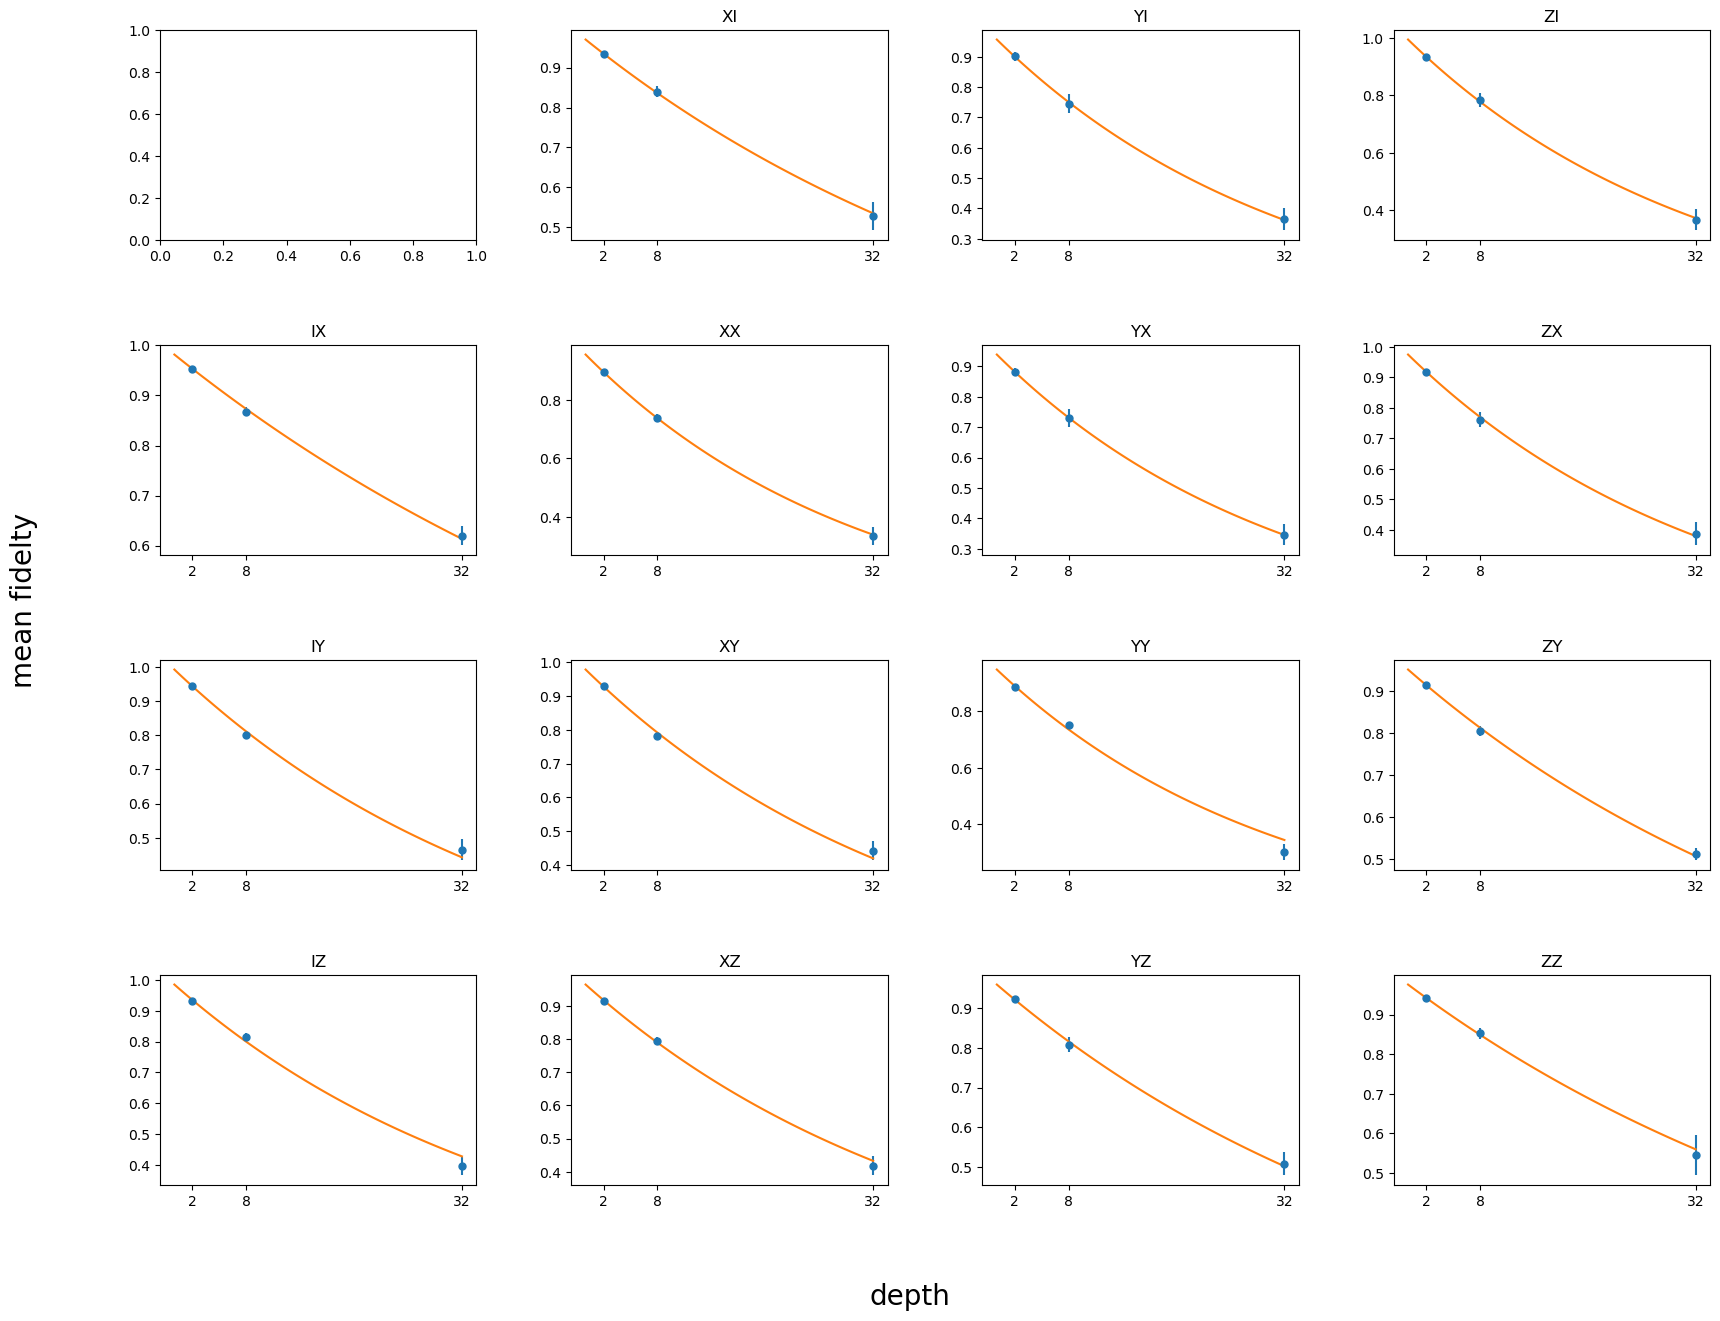

In [10]:
data=cb_data
full_raw_fidelity_list={}
n = data["n"]
pauli_sample_list = data["pauli_sample_list"]
fidelity_list = {} 
stdev_list = {}
Yd3_dic={}
Yerrd3_dic={}
ad3_dic={}
for pauli_sample in pauli_sample_list:
    cb_data_temp = data[pauli_sample]

    # n = cb_data["parameters"]['n']
    # n_total = cb_data["parameters"]['n_total'] 
    shots = cb_data_temp ["parameters"]['shots'] 
    Lrange = depth
    C = cb_data_temp ["parameters"]['C'] 
#     eps_readout = cb_data_temp ["parameters"]['eps_readout'] 
#     repeat = cb_data_temp ["parameters"]['repeat']
#     pdb.set_trace()
    cb_result = CB_process_modified.process_CB(n, C, shots, 1, Lrange, cb_data_temp , pauli_sample = pauli_sample, periodic=True,use_density_matrix=False, intercept_cb=False)
    raw_fidelity_list = cb_result["fidelity_list"]
    # print (raw_fidelity_list["XX"])
    #correct nagetive values
    for key in raw_fidelity_list:
#     print (key)
        for dep in Lrange:
            raw_fidelity_list[key][dep]=[abs(value) for value in raw_fidelity_list[key][dep] ]
        
    full_raw_fidelity_list.update(raw_fidelity_list)
    new_sub_label = []

    for sub_label in raw_fidelity_list.keys():
        if sub_label in fidelity_list:
            continue # wasteful!
        elif(sub_label == 'I'*n):
            fidelity_list[sub_label] = 1.0
            stdev_list[sub_label] = 0.0
        else:
#             alpha, alpha_err = CB_process_modified.fit_CB(Lrange, raw_fidelity_list[sub_label])
            alpha,a, alpha_err,Y, Yerr  = fit_CB_plot(Lrange, raw_fidelity_list[sub_label])
            fidelity_list[sub_label] = alpha
            stdev_list[sub_label] = alpha_err
            new_sub_label.append(sub_label)
            ad3_dic[sub_label]=a 
            Yd3_dic[sub_label]=Y
            Yerrd3_dic[sub_label]=Yerr

    print("CB setting: ",pauli_sample[::-1]," Pauli fidelities calculated: ", [sub_label[::-1] for sub_label in new_sub_label])


print("Parameters: n = %d, C = %d, " % (n,C), "L = ", str(Lrange))
# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))
print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
    
    
    
# plot_248={}
# plot_248=deepcopy(plot_dic)
# err_248=deepcopy(error_dic)
# print (Y248_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(Lrange)   
            axs[i, j].errorbar(Lrange,Yd3_dic[pauli_label], yerr=Yerrd3_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,ad3_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        
# for key in full_raw_fidelity_list:
#     print (key)

Label / Pauli error rates
II 0.9773156120201246
XI 0.003316310039886257
YI 0.000726399085608273
ZI 0.0027458307095692552
IX 0.0010214217706930387
XX 0.005013747496398345
YX 0.002518368662503101
ZX 0.0008772714487560451
IY 0.0006106672192892695
XY 0.0023470402966412687
YY -0.00020280326985978175
ZY 0.0006951643463864662
IZ 0.0023790793957250075
XZ 0.0007154969015469373
YZ 0.0006504834683638896
ZZ -0.0007300895916318925


<BarContainer object of 15 artists>

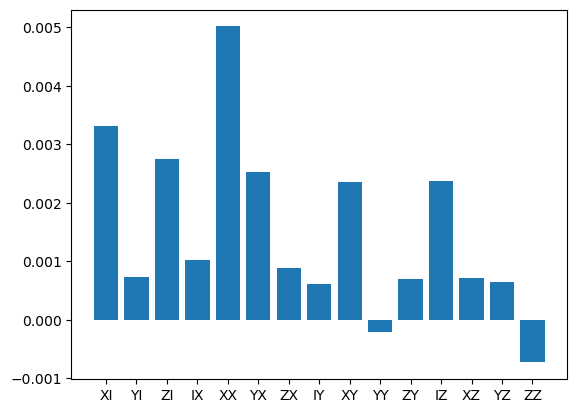

In [43]:
error_list = fidelity_to_error(fidelity_list,n)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

plt.bar([pauli_label[::-1] for pauli_label in pauli_request_list[1:]],[error_list[pauli_label] for pauli_label in pauli_request_list[1:]])

Scatter plot: rersults from each circuit

In [11]:

# Y_full_dic=Yd3_dic
# Yerr_full_dic=Yerrd3_dic
# a_full_dic=ad3_dic
# x_c=np.linspace(0,32,num=80)
# # nqubit=2
# fig, axs = plt.subplots(8, 2)
# fig.set_figwidth(10)
# fig.set_figheight(50)
# fig.subplots_adjust(hspace=0.5,wspace=0.3) 
# fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
# fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (8):
#     for j in range(2):
#         pauli_label=pauli_request_list[2*i+j]
#         if (pauli_label == 'I'*nqubit):
# #                 fidelity_list[pauli_label] = 1.0
# #                 stdev_list[pauli_label] = 0.0
#             pass
#         else:
#             axs[i, j].set_xticks(depth)   
# #             print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
#             axs[i, j].plot(depth,[tuple(full_raw_fidelity_list[pauli_label][L]) for L in depth],"*",markersize=3)
#             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=8)
#             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
                
# # for pauli_label in pauli_request_list:
# # fig.savefig("fit_scatter.pdf", format="pdf", dpi=500)        

data analysis: bootstrapping (The figure in this section is the average over multiple bootstrap results. It is just a guide to the eye and it's not important. The extracted average Pauli infidelity is the only important quantity)

In [22]:

depth=[2,8,32]
raw_fidelity_list = full_raw_fidelity_list
plot_dic={}
error_dic={}
# sys.exit(0)
# depth=[2,8,16,32,40]
fidelity_list = {}
stdev_list = {}
alpha_detail={}
a_detail={}
alpha_error_detail={}
Y_detail={}
Y_err_detail={}
a_dic={}
Y_dic={}
Yerr_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],19)
        fidelity_list[pauli_label] = alpha_bootstrap #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err_bootstrap #error on pauli fidelity from fit
        alpha_detail[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
        a_dic[pauli_label]=sum(a_rtn_frm_fit)/len(a_rtn_frm_fit)
        Y_detail[pauli_label]=Y_rtn_frm_fit
        Y_err_detail[pauli_label]=Yerr_rtn_frm_fit
        

#         for dep in [2,8,32]:
#             raw_fidelity_list[key][dep]=[abs(value) for value in raw_fidelity_list[key][dep] ]
        
for pauli_label in pauli_request_list:
    Y_dic[pauli_label]={}
    Y_dic[pauli_label][2]=[]
    Y_dic[pauli_label][8]=[]
    Y_dic[pauli_label][16]=[]
    Y_dic[pauli_label][32]=[]
    Y_dic[pauli_label][40]=[]
    if pauli_label=="II":
        for i in range (len(Y_detail["XX"])):
            Y_dic[pauli_label][2].append(1)
            Y_dic[pauli_label][8].append(1)
            Y_dic[pauli_label][16].append(1)
            Y_dic[pauli_label][32].append(1)
            Y_dic[pauli_label][40].append(1)
        continue
    else:
        for i in range (len(Y_detail[pauli_label])):
            Y_dic[pauli_label][2].append(Y_detail[pauli_label][i][0])
            Y_dic[pauli_label][8].append(Y_detail[pauli_label][i][1])
            Y_dic[pauli_label][16].append(Y_detail[pauli_label][i][2])
            Y_dic[pauli_label][32].append(Y_detail[pauli_label][i][3])
            Y_dic[pauli_label][40].append(Y_detail[pauli_label][i][4])
# print ("Y_dic")
# print (Y_dic)

        
print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))        
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        continue
    else:
        print (pauli_label[::-1],round(1-fidelity_list[pauli_label],7),round(stdev_list[pauli_label],7))

# print (alpha_detail[pauli_label])
error_list = fidelity_to_error(fidelity_list,n)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(depth)   
            axs[i, j].plot(depth,[tuple(Y_dic[pauli_label][L]) for L in depth],"*",markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])


IndexError: list index out of range

plot how Pauli infidelities changes with layer


scatter plot: result from each circuit

# data analysis with bootstrapping

full set of data with bootstrapping

IndexError: list index out of range

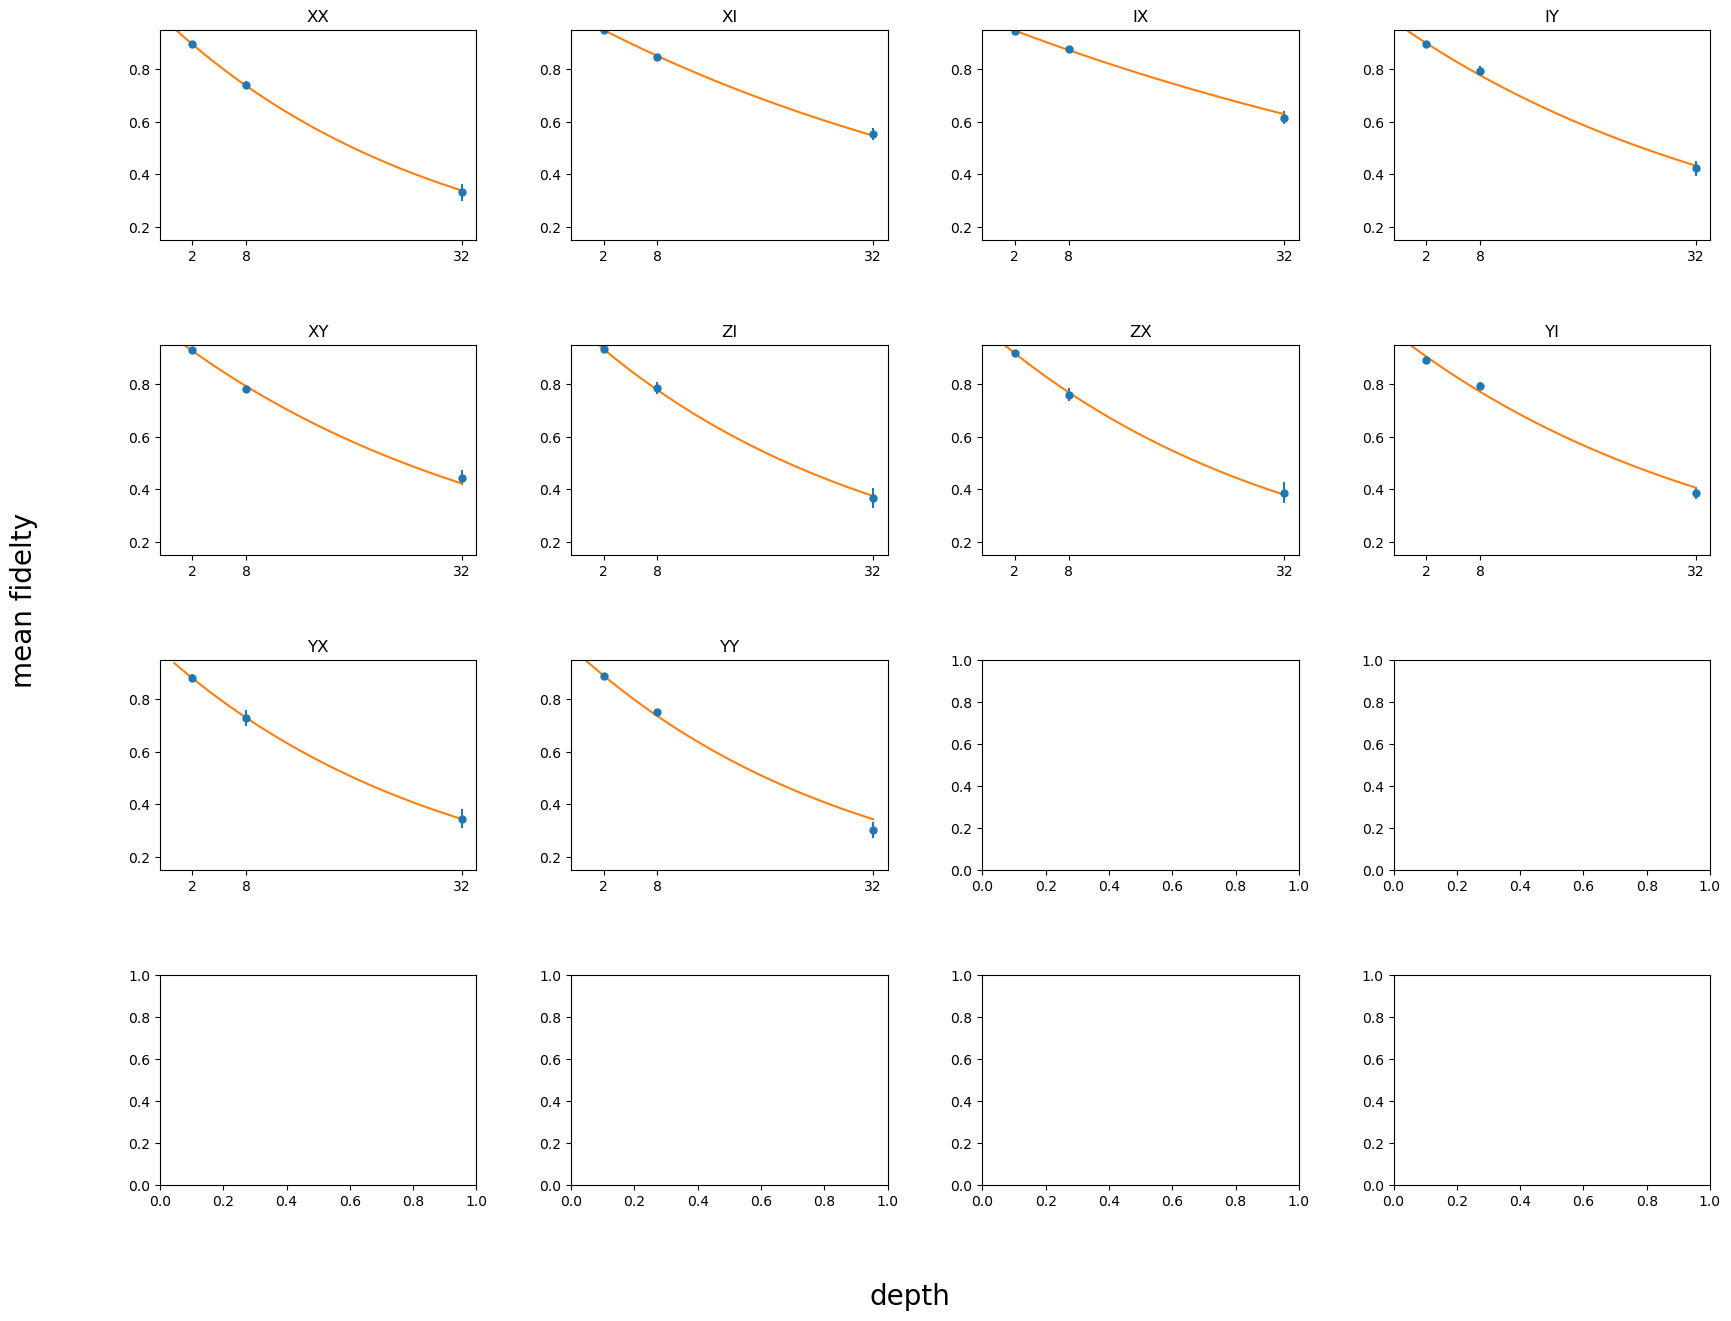

In [16]:
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)

bootstrap_and_plot_method_1(axs, pauli_request_list,nqubit,depth, full_raw_fidelity_list,sample_size=19)

Method I: use the average of the 10 sets of Pauli fidelities from 10 times of resampling in bootstrapping


In [11]:
# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         continue
#     else:
#         print (pauli_label[::-1],round(1-fidelity_list[pauli_label],7),round(stdev_list[pauli_label],7))


# x_c=np.linspace(0,32,num=80)
# nqubit=2
# fig, axs = plt.subplots(4, 4)
# fig.set_figwidth(20)
# fig.set_figheight(15)
# fig.subplots_adjust(hspace=0.5,wspace=0.3) 
# fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
# fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
# #                 fidelity_list[pauli_label] = 1.0
# #                 stdev_list[pauli_label] = 0.0
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             for m in range (10):
#                 axs[i, j].errorbar(depth,Y_BS_dic[pauli_label][m], yerr=Yerr_BS_dic[pauli_label][m], fmt='o',markersize=5)
#                 axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_BS_dic[pauli_label][m], alpha_detail[pauli_label][m]))
#             axs[i, j].set_title(pauli_label[::-1])

# print (alpha_detail)    

Method II: use the average of the 10 sets of Y from resampling as the a new set of Y and do the fit once with the new Y


In [12]:
# raw_fidelity_list_avg={}
# for pauli_label in pauli_request_list:
#     raw_fidelity_list_avg[pauli_label]={}
#     raw_fidelity_list_avg[pauli_label][2]=[]
#     raw_fidelity_list_avg[pauli_label][4]=[]
#     raw_fidelity_list_avg[pauli_label][8]=[]
#     raw_fidelity_list_avg[pauli_label][16]=[]
#     raw_fidelity_list_avg[pauli_label][32]=[]
#     if (pauli_label=="II"):
#         raw_fidelity_list_avg[pauli_label][2]=[1.0]*10
#         raw_fidelity_list_avg[pauli_label][4]=[1.0]*10
#         raw_fidelity_list_avg[pauli_label][8]=[1.0]*10
#         raw_fidelity_list_avg[pauli_label][16]=[1.0]*10
#         raw_fidelity_list_avg[pauli_label][32]=[1.0]*10
#     else:
#         for i in range (10):
#             raw_fidelity_list_avg[pauli_label][2].append(Y_BS_dic[pauli_label][i][0])
#             raw_fidelity_list_avg[pauli_label][4].append(Y_BS_dic[pauli_label][i][1])
#             raw_fidelity_list_avg[pauli_label][8].append(Y_BS_dic[pauli_label][i][2])
#             raw_fidelity_list_avg[pauli_label][16].append(Y_BS_dic[pauli_label][i][3])
#             raw_fidelity_list_avg[pauli_label][32].append(Y_BS_dic[pauli_label][i][4])


# raw_fidelity_list = raw_fidelity_list_avg
# plot_dic={}
# error_dic={}
# # sys.exit(0)
# depth=[2,4,8,16,32]
# fidelity_list = {}
# stdev_list = {}
# a_full_dic={}
# Y_full_dic={}
# Yerr_full_dic={}
# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha #pauli fidelity from fit
#         stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
#         a_full_dic[pauli_label]=a 
#         Y_full_dic[pauli_label]=Y
#         Yerr_full_dic[pauli_label]=Yerr

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=2000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
#     error_dic[pauli_label[::-1]]=stdev_list[pauli_label]


# plot_full={}
# plot_full=deepcopy(plot_dic)
# err_full=deepcopy(error_dic)
# print (Y_full_dic)

# x_c=np.linspace(0,32,num=80)
# nqubit=2
# fig, axs = plt.subplots(4, 4)
# fig.set_figwidth(20)
# fig.set_figheight(15)
# fig.subplots_adjust(hspace=0.5,wspace=0.3) 
# fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
# fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# plt.rcParams.update({'font.size': 15})
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].errorbar(depth,[1,1,1,1,1], yerr=[0,0,0,0,0], fmt='o',markersize=8)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,1, [1,1,1,1,1]))
#             axs[i, j].set_title(pauli_label[::-1])
#             axs[i, j].set_ylim(bottom=0,top=1.05)
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=8)
#             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]),linewidth=3)
#             axs[i, j].set_title(pauli_label[::-1])
                
# # for pauli_label in pauli_request_list:
# #     fig.savefig("eab_fit", format="png", dpi=500)  
# fig.savefig("eab_fit.pdf", format="pdf", dpi=500)  

In [13]:
# error_list = fidelity_to_error(fidelity_list,nqubit)
# print("Label / Pauli error rates")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], round(error_list[pauli_label],7))


# Bootstrapping for different number of layers
Obtain the lists of:  
    alpha_detail[pauli_label]=alpha_rtn_frm_fit
    alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
for different number of layers

plot alpha_detail vs. number of layers

In [11]:
# ######dpth=[2,8]
raw_fidelity_list = full_raw_fidelity_list
# # raw_fidelity_list = eab_result["fidelity_list"]
# depth=[2,8,16]
# fidelity_list = {}
# stdev_list = {}
# a_detail={}
# Y_detail={}
# Y_err_detail={}
# a_BS_dic={}
# Y_BS_dic={}
# Yerr_BS_dic={}

# alpha_detail_d2={}
# alpha_error_detail_d2={}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         alpha_detail_d2[pauli_label] = [1.0]*10
#         alpha_error_detail_d2[pauli_label] = [0.0]*10
#     else:
#         alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],19)
#         alpha_detail_d2[pauli_label]=alpha_rtn_frm_fit
#         alpha_error_detail_d2[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_d2)

# ######dpth=[2,4,8]
# # raw_fidelity_list = eab_result["fidelity_list"]
# depth=[8,16,32]
# fidelity_list = {}
# stdev_list = {}
# a_detail={}
# Y_detail={}
# Y_err_detail={}
# a_BS_dic={}
# Y_BS_dic={}
# Yerr_BS_dic={}

# alpha_detail_d3={}
# alpha_error_detail_d3={}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         alpha_detail_d3[pauli_label] = [1.0]*10
#         alpha_error_detail_d3[pauli_label] = [0.0]*10
#     else:
#         alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],19)
#         alpha_detail_d3[pauli_label]=alpha_rtn_frm_fit
#         alpha_error_detail_d3[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_d3)

#####dpth=[2,4,8,16]
# raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,8,32]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d4={}
alpha_error_detail_d4={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d4[pauli_label] = [1.0]*10
        alpha_error_detail_d4[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],19)
        alpha_detail_d4[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d4[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_2)

# ####depth=[2,4,8,16,32]
# alpha_detail_d5={}
# alpha_error_detail_d5={}
# alpha_detail_d5= alpha_detail
# alpha_error_detail_d5=alpha_error_detail
# alpha_detail_d5["II"] = [1.0]*10
# alpha_error_detail_d5["II"] = [0.0]*10

In [12]:
# filename = str(uuid.uuid4())
# filename="CB_alpha_detail_d2816"
# with open("/Users/yzhu/yzhu_work/gates projects/EAB/data/for plotting/bootstrap19samples/CB_FTXX45_052024/"+filename, "wb") as fp:
#     pickle.dump(alpha_detail_d2, fp)

# filename="CB_alpha_detail_d2816_error"
# with open("/Users/yzhu/yzhu_work/gates projects/EAB/data/for plotting/bootstrap19samples/CB_FTXX45_052024/"+filename, "wb") as fp:
#     pickle.dump(alpha_error_detail_d2, fp)


# # filename="CB_alpha_detail_d81632"
# # with open("/Users/yzhu/yzhu_work/gates projects/EAB/data/for plotting/bootstrap19samples/CB_FTXX45_052024/"+filename, "wb") as fp:
# #     pickle.dump(alpha_detail_d3, fp)
# filename="CB_alpha_detail_d81632_error"
# with open("/Users/yzhu/yzhu_work/gates projects/EAB/data/for plotting/bootstrap19samples/CB_FTXX45_052024/"+filename, "wb") as fp:
#     pickle.dump(alpha_error_detail_d3, fp)

filename="CB_alpha_detail_d2832"
with open("/Users/yzhu/yzhu_work/gates projects/EAB/data/for plotting/bootstrap19samples/CB_FTXX45_0927/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d4, fp)
filename="CB_alpha_detail_d2832_error"
with open("/Users/yzhu/yzhu_work/gates projects/EAB/data/for plotting/bootstrap19samples/CB_FTXX45_0927/"+filename, "wb") as fp:
    pickle.dump(alpha_error_detail_d4, fp)